# Clustering
We will attempt to make some sense of the data we have using clustering algorithms from scikit-learn.
Some of the algorithms explored are: k-means clustering, affinity propagation and dbscan.

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import csv

%run 'preprocessor.ipynb' #our own preprocessor functions

with open('data_w1w4.csv', 'r') as f:
      reader = csv.reader(f)
      data = list(reader)
    
matrix = obtain_data_matrix(data)
samples = len(matrix)

print("Number of samples: " + str(samples))

Number of samples: 176


### Principle Component Analysis (PCA)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


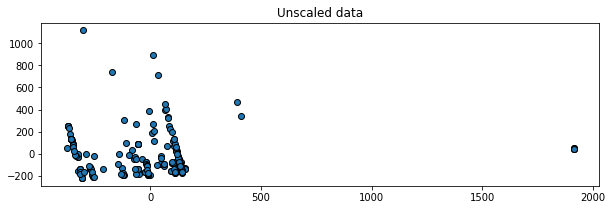

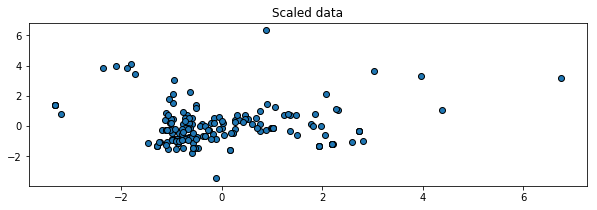

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

fig = plt.figure(1, figsize=(10, 3))
plt.clf()

plt.cla()
pca = PCA(n_components=2)
pca.fit(matrix)
X = pca.transform(matrix)
plt.title('Unscaled data')
plt.scatter(X[:, 0], X[:, 1], edgecolor='k')

matrix_scaled = scale(matrix)

fig = plt.figure(2, figsize=(10, 3))
plt.clf()

plt.cla()
pca = PCA(n_components=2)
pca.fit(matrix_scaled)
X = pca.transform(matrix_scaled)
plt.title('Scaled data')
plt.scatter(X[:, 0], X[:, 1], edgecolor='k')
plt.show()

### Benchmarking

In [3]:
from sklearn.cluster import KMeans

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=samples)))

labels = (np.array(matrix[:,[0]])).flatten()

print("Benchmarks without PCA:")

bench_k_means(KMeans(init='k-means++', n_clusters=5, n_init=10), name="k-means++", data=matrix)
bench_k_means(KMeans(init='random', n_clusters=5, n_init=10), name="random", data=matrix)

print("\nBenchmarks with PCA:")

pca = PCA(n_components=5).fit(matrix)
bench_k_means(KMeans(init=pca.components_, n_clusters=5, n_init=1), name="PCA-based", data=matrix)

Benchmarks without PCA:
k-means++	0.04s	3336501	0.293	0.799	0.429	0.140	0.201	0.524
random   	0.03s	3336501	0.293	0.799	0.429	0.140	0.201	0.524

Benchmarks with PCA:
PCA-based	0.00s	3409567	0.281	0.818	0.418	0.119	0.192	0.530


### Visualise PCA-reduced data with k-means clustering

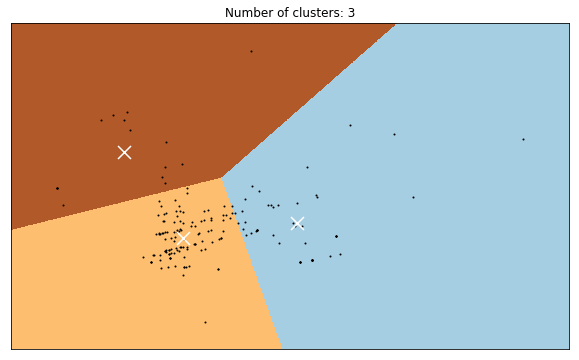

In [4]:
i = 3
target_clusters = i

reduced_data = PCA(n_components=2).fit_transform(matrix_scaled)
kmeans = KMeans(init='k-means++', n_clusters=target_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(i, figsize=(10, 6))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.title('Number of clusters: %d' % target_clusters)
plt.show()

### Visualise PCA-reduced data with affinity propagation

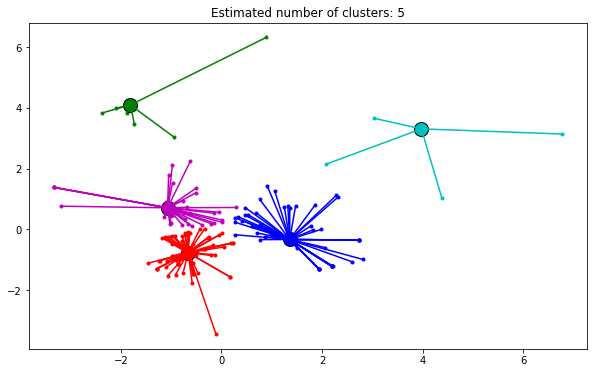

Estimated number of clusters: 5
Homogeneity: 0.253
Completeness: 1.000
V-measure: 0.404
Adjusted Rand Index: 0.006
Adjusted Mutual Information: 0.024
Silhouette Coefficient: 0.568


In [5]:
from sklearn.cluster import AffinityPropagation
from itertools import cycle

af = AffinityPropagation(preference=-50).fit(reduced_data)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

labels_true = reduced_data[:, 1]
n_clusters_ = len(cluster_centers_indices)

plt.close('all')
plt.figure(1, figsize=(10, 6))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

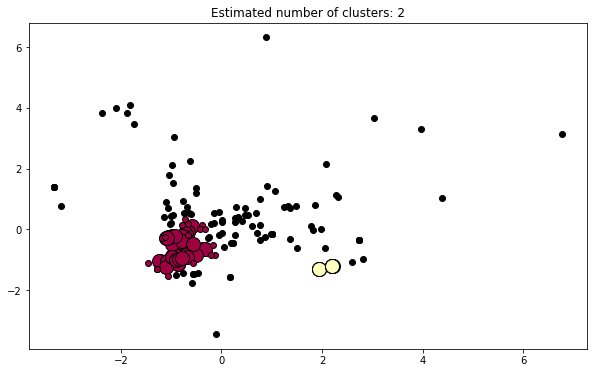

Estimated number of clusters: 2
Homogeneity: 0.171
Completeness: 1.000
V-measure: 0.292
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.017
Silhouette Coefficient: 0.163


In [6]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(1, figsize=(10, 6))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))